# Final Capstone notebook

The different models that were trained and pickled in the previous notebooks will be discussed below. 
Furthermore, the different evaluation dataframes that were likewise populated in the preceding notebooks will also be imported and processed. 

The built-in SageMaker XGBoost algorithm (v0.90-2) is the last model that was used to process the synthetic dataset. 
In the final segment of the notebook, at the model training segment, the model artifacts were manually downloaded from the output S3 directory
and deserialized in a separate python file intended for deploying an invocations endpoint using Flask.

---

In [1]:
import pandas as pd
import numpy as np
import sagemaker

In [2]:
np.set_printoptions(suppress=True, precision=2)
pd.set_option('display.float_format', lambda x: '%.10f' % x)

### Import synthetic training and validation data from corresponding directory and verify data integrity
---

In [3]:
training_df = pd.read_csv('files/capstone/data/training_data.csv')
validation_df = pd.read_csv('files/capstone/data/validation_data.csv')
test_df = pd.read_csv('files/capstone/data/test_data.csv')

In [4]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       640 non-null    float64
 1   1       640 non-null    float64
 2   2       640 non-null    float64
 3   3       640 non-null    float64
 4   4       640 non-null    float64
 5   5       640 non-null    float64
 6   6       640 non-null    float64
 7   target  640 non-null    float64
dtypes: float64(8)
memory usage: 40.1 KB


In [5]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       200 non-null    float64
 1   1       200 non-null    float64
 2   2       200 non-null    float64
 3   3       200 non-null    float64
 4   4       200 non-null    float64
 5   5       200 non-null    float64
 6   6       200 non-null    float64
 7   target  200 non-null    float64
dtypes: float64(8)
memory usage: 12.6 KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       160 non-null    float64
 1   1       160 non-null    float64
 2   2       160 non-null    float64
 3   3       160 non-null    float64
 4   4       160 non-null    float64
 5   5       160 non-null    float64
 6   6       160 non-null    float64
 7   target  160 non-null    float64
dtypes: float64(8)
memory usage: 10.1 KB


### For CSV training, the algorithm assumes that the target variable is in the first column and that the CSV does not have a header record. For CSV inference, the algorithm assumes that CSV input does not have the label column.
---

In [7]:
training_df = training_df[['target', '0', '1', '2', '3', '4', '5', '6']]
validation_df = validation_df[['target', '0', '1', '2', '3', '4', '5', '6']]
test_df = test_df[['target', '0', '1', '2', '3', '4', '5', '6']]

In [8]:
training_df.head()

,target,0,1,2,3,4,5,6
0,-41.8502760874,-1.9782252494,1.8977670167,0.0469349021,0.8946471876,-0.9478927173,0.3514799004,-1.3728594515
1,-3.2836211045,0.2680504276,-0.0511186930,0.7151743901,-0.6529501558,0.0161247879,-0.3152663339,-0.5497893596
2,114.7073731291,0.5531491564,1.9234457948,-0.5482002982,-1.1234940332,-0.7746149700,-2.0820987032,0.2428820132
3,177.0925284831,-0.5536493053,1.9647251329,-1.1978778926,-0.7928728323,0.0352635520,-1.0352423224,-0.1070303600
4,101.4439089887,-0.2209695995,0.7575077100,0.6141667000,-0.6997255080,-0.5305011476,-0.1123280497,0.2139799107


In [9]:
training_df.to_csv('files/capstone/data/updated_training_data.csv', header=False, index=False)
validation_df.to_csv('files/capstone/data/updated_validation_data.csv', header=False, index=False)
test_df.to_csv('files/capstone/data/updated_test_data.csv', header=False, index=False)

## Verify data integrity
---

In [10]:
!cat files/capstone/data/updated_training_data.csv

-41.85027608737949,-1.9782252493748105,1.8977670167459768,0.046934902060369633,0.8946471875738723,-0.9478927172689864,0.3514799003522017,-1.372859451481064
-3.2836211045380628,0.2680504275897533,-0.051118693015377664,0.7151743901280584,-0.6529501558320808,0.016124787900472438,-0.3152663339162557,-0.5497893596380333
114.70737312905241,0.5531491563792091,1.9234457948249533,-0.5482002981667726,-1.1234940332395977,-0.7746149700185819,-2.0820987031889877,0.24288201315027497
177.09252848314526,-0.553649305347182,1.9647251329163893,-1.1978778925888485,-0.7928728322623442,0.03526355197172861,-1.035242322419374,-0.10703035995455784
101.44390898869759,-0.22096959953322295,0.7575077100473051,0.6141667000434252,-0.6997255079925856,-0.5305011476105275,-0.11232804969082982,0.21397991073422198
155.2208083970355,0.6266136372630708,0.6234071382799156,0.04556388114189831,-1.6167133749480145,0.7034401331388942,-0.24861585376667736,-0.2293823318554672
-83.11237668092389,-2.929448690002268,1.08876965421667

## Process input data using the upload_data and TrainingInput methdos
---

In [11]:
sesh = sagemaker.Session()

train_s3_path = sesh.upload_data("files/capstone/data/updated_training_data.csv")
val_s3_path = sesh.upload_data("files/capstone/data/updated_validation_data.csv")
test_s3_path = sesh.upload_data("files/capstone/data/updated_test_data.csv")

In [12]:
from sagemaker.inputs import TrainingInput
    
s3_input_training = TrainingInput(train_s3_path, content_type="text/csv")
s3_input_validation = TrainingInput(val_s3_path, content_type="text/csv")

## Install and/or upgrade the relevant and necessary packages in the current Jupyter kernel
---

In [13]:
import sys

!{sys.executable} -m pip install 'sagemaker[local]' --upgrade
!{sys.executable} -m pip install xgboost==0.90

     |████████████████████████████████| 413 kB 19.5 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.42.1-py2.py3-none-any.whl size=580659 sha256=83835ccf11a3c85a4660e115c1e034dce9123ec3ece647efd85fcbd9880ab4c5
  Stored in directory: /home/ec2-user/.cache/pip/wheels/36/73/72/147e239a958fa69f277e3077dc08b53cbf466cf443463147bd
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.41.0
    Uninstalling sagemaker-2.41.0:
      Successfully uninstalled sagemaker-2.41.0
     |████████████████████████████████| 142.8 MB 34 kB/s s eta 0:00:01    |███████████████████             | 84.7 MB 69.1 MB/s eta 0:00:01     |█████████████████████▎          | 94.8 MB 69.1 MB/s eta 0:00:01     |██████████████████████████▊     | 119.3 MB 69.1 MB/s eta 0:00:01


## Model training and automatic hyperparameter tuning

In this segment, the SageMaker XGBoost model's hyperparameters will be tuned using SageMaker's automatic model tuning process. 

***Note:*** Given that Amazon SageMaker was used, the instance types used in this notebook are all part of the AWS Free Tier. 

**See more here:** https://aws.amazon.com/sagemaker/pricing/

---

In [14]:
import boto3
import sagemaker
from sagemaker import tuner
from sagemaker import get_execution_role

role = get_execution_role()
bucket = sesh.default_bucket()
region = boto3.Session().region_name    
client = boto3.Session().client('sagemaker')

In [15]:
from sagemaker.image_uris import retrieve

container = retrieve('xgboost', region, version="0.90-2")
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

In [16]:
!sudo service docker restart

Stopping docker: [  OK  ]
Starting docker:	.[  OK  ]


In [17]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    sagemaker_session=sesh
)

In [18]:
estimator.set_hyperparameters(
    eval_metric='rmse',
    objective='reg:squarederror'
)

In [19]:
hyperparameter_ranges = {
    'alpha': tuner.ContinuousParameter(0, 1000),
    'num_round': tuner.IntegerParameter(1, 4000),
    'eta': tuner.ContinuousParameter(0.1, 0.5),
    'min_child_weight': tuner.ContinuousParameter(0, 120),
    'max_depth': tuner.IntegerParameter(0, 10),
    'subsample': tuner.ContinuousParameter(0.5, 1)
}

In [20]:
objective_metric_name = 'validation:rmse'

In [21]:
hyperparameter_tuner = tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges, 
    objective_type='Minimize',
    max_jobs=20,
    max_parallel_jobs=5
)

In [38]:
hyperparameter_tuner.fit(
    {'train': s3_input_training, 'validation': s3_input_validation},
    include_cls_metadata=False,
    wait=False
)

job_name = hyperparameter_tuner.latest_tuning_job.job_name

response = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name
)

response['HyperParameterTuningJobStatus']

'InProgress'

In [39]:
from pprint import pprint

pprint(response)

{'CreationTime': datetime.datetime(2021, 5, 28, 8, 23, 1, 662000, tzinfo=tzlocal()),
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:305262579855:hyper-parameter-tuning-job/sagemaker-xgboost-210528-0823',
 'HyperParameterTuningJobConfig': {'HyperParameterTuningJobObjective': {'MetricName': 'validation:rmse',
                                                                        'Type': 'Minimize'},
                                   'ParameterRanges': {'CategoricalParameterRanges': [],
                                                       'ContinuousParameterRanges': [{'MaxValue': '1000',
                                                                                      'MinValue': '0',
                                                                                      'Name': 'alpha',
                                                                                      'ScalingType': 'Auto'},
                                                                          

In [40]:
hyperparameter_tuner.__dict__

{'estimator': <sagemaker.estimator.Estimator at 0x7f0a5019a198>,
 'objective_metric_name': 'validation:rmse',
 '_hyperparameter_ranges': {'alpha': <sagemaker.parameter.ContinuousParameter at 0x7f0a502f5e80>,
  'num_round': <sagemaker.parameter.IntegerParameter at 0x7f0a50314438>,
  'eta': <sagemaker.parameter.ContinuousParameter at 0x7f0a50314400>,
  'min_child_weight': <sagemaker.parameter.ContinuousParameter at 0x7f0a503143c8>,
  'max_depth': <sagemaker.parameter.IntegerParameter at 0x7f0a50314940>,
  'subsample': <sagemaker.parameter.ContinuousParameter at 0x7f0a503146d8>},
 'metric_definitions': None,
 'estimator_dict': None,
 'objective_metric_name_dict': None,
 '_hyperparameter_ranges_dict': None,
 'metric_definitions_dict': None,
 'static_hyperparameters_dict': None,
 'strategy': 'Bayesian',
 'objective_type': 'Minimize',
 'max_jobs': 20,
 'max_parallel_jobs': 5,
 'tags': None,
 'base_tuning_job_name': None,
 '_current_job_name': 'sagemaker-xgboost-210528-0823',
 'latest_tuning_

In [41]:
tuning_job_name = response['HyperParameterTuningJobName']
%store tuning_job_name

tuning_job_name

Stored 'tuning_job_name' (str)


'sagemaker-xgboost-210528-0823'

In [ ]:
from time import sleep

while response['HyperParameterTuningJobStatus'] == 'InProgress':
    response = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=job_name
    )

    print(response['HyperParameterTuningJobStatus'])
    sleep(60)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress


## After all hyperparameter tuning jobs are finished, a HyperparameterTuningJobAnalytics object is instantiated to display all of the results

The data has also been sorted such that the model with the lowest Root Mean Squared Error is displayed first.

---

In [57]:
%store -r tuning_job_name

from sagemaker import HyperparameterTuningJobAnalytics

def latest_df():
    analytics = HyperparameterTuningJobAnalytics(tuning_job_name)

    return analytics.dataframe()    

# display model with lowest loss value first
latest_df().sort_values('FinalObjectiveValue', ascending=True) 

,alpha,eta,max_depth,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
7,751.3553729265,0.3108131024,1.0000000000,13.4320781837,546.0000000000,0.6712609607,sagemaker-xgboost-210528-0823-013-d5e9d8b6,Completed,55.0096015930,2021-05-28 08:34:26+00:00,2021-05-28 08:35:48+00:00,82.0000000000
5,676.5152850359,0.1927833173,2.0000000000,0.0000000000,116.0000000000,0.7118035633,sagemaker-xgboost-210528-0823-015-67c0160c,Completed,55.4855003357,2021-05-28 08:36:12+00:00,2021-05-28 08:37:32+00:00,80.0000000000
2,696.5152850359,0.1927833173,2.0000000000,0.0000000000,139.0000000000,0.7118035633,sagemaker-xgboost-210528-0823-018-e2b31449,Completed,56.1423988342,2021-05-28 08:38:53+00:00,2021-05-28 08:40:15+00:00,82.0000000000
4,940.8280291765,0.2270240399,1.0000000000,10.3266094337,90.0000000000,0.5894738514,sagemaker-xgboost-210528-0823-016-2f77422c,Completed,57.9208984375,2021-05-28 08:38:26+00:00,2021-05-28 08:39:49+00:00,83.0000000000
6,819.5926776140,0.2090064618,1.0000000000,52.6752422462,96.0000000000,0.7422448475,sagemaker-xgboost-210528-0823-014-5e610981,Completed,58.0563011169,2021-05-28 08:34:28+00:00,2021-05-28 08:35:48+00:00,80.0000000000
10,950.2274432390,0.2446431805,9.0000000000,23.3467266212,128.0000000000,0.7216149646,sagemaker-xgboost-210528-0823-010-a6e5030c,Completed,58.0575981140,2021-05-28 08:32:10+00:00,2021-05-28 08:33:31+00:00,81.0000000000
3,724.9466815203,0.3443336102,8.0000000000,9.3671367775,220.0000000000,0.5972558338,sagemaker-xgboost-210528-0823-017-bdcdf99a,Completed,60.4906005859,2021-05-28 08:38:36+00:00,2021-05-28 08:39:54+00:00,78.0000000000
9,157.2391619890,0.1110572430,8.0000000000,38.8178203712,219.0000000000,0.7057458240,sagemaker-xgboost-210528-0823-011-7d17d408,Completed,61.0527992249,2021-05-28 08:34:20+00:00,2021-05-28 08:35:34+00:00,74.0000000000
18,990.3572128218,0.2237332462,9.0000000000,76.8418925663,61.0000000000,0.8915699063,sagemaker-xgboost-210528-0823-002-5688389e,Completed,61.1469001770,2021-05-28 08:26:03+00:00,2021-05-28 08:27:16+00:00,73.0000000000
11,157.2391619890,0.1110572430,8.0000000000,41.2178203712,219.0000000000,0.7057458240,sagemaker-xgboost-210528-0823-009-1da52f76,Completed,61.3031997681,2021-05-28 08:30:22+00:00,2021-05-28 08:31:40+00:00,78.0000000000


#### Afterwards, the best model's parameters are copied onto a new estimator. The output_path variable is also set to a specific directory where we want our model artifacts to be stored after the training is finished.
---

In [22]:
boost = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    sagemaker_session=sesh,
    output_path='s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/capstone-model/'
)

boost.set_hyperparameters(
    eval_metric='rmse',
    objective='reg:squarederror',
    alpha=751.355372926535,
    num_round=546,
    eta=0.31081310241766846,
    min_child_weight=13.432078183705151,
    max_depth=1,
    subsample=0.6712609607342778
)

In [23]:
boost.fit(inputs={'train': s3_input_training, 'validation': s3_input_validation})

2021-05-29 06:58:20 Starting - Starting the training job...
2021-05-29 06:58:22 Starting - Launching requested ML instancesProfilerReport-1622271499: InProgress
......
2021-05-29 06:59:48 Starting - Preparing the instances for training.........
2021-05-29 07:01:11 Downloading - Downloading input data...
2021-05-29 07:01:49 Training - Downloading the training image...
2021-05-29 07:02:18 Uploading - Uploading generated training model
2021-05-29 07:02:18 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined deli

In [24]:
boost

In [25]:
import xgboost as xgb

# load a LIBSVM text file or a XGBoost binary file into DMatrix object 
# (an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed)
xgmat = xgb.DMatrix(validation_df[['0', '1', '2', '3', '4', '5', '6']].values)

## Deserialize model artifacts

The model artifacts stored in the aforementioned output_path is then manually downloaded and stored in a local directory.
The tarfile and pickle libraries are used in the deserialization process.

---

In [26]:
import pickle as pkl 
import tarfile

# extract model from tar file and deserialize using pickle
t = tarfile.open('files/capstone/model.tar.gz', 'r:gz')
t.extractall()

xgb_model = pkl.load(open('xgboost-model', 'rb'))

# prediction with test data
xgb_preds = xgb_model.predict(xgmat)
len(xgb_preds)

200

## Plot the relationship between the actual and predicted data of the SageMaker XGBoost model
---

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '\nSageMaker XGBoost v0.90-2\nValidation data\nActual vs. Predicted values\n')

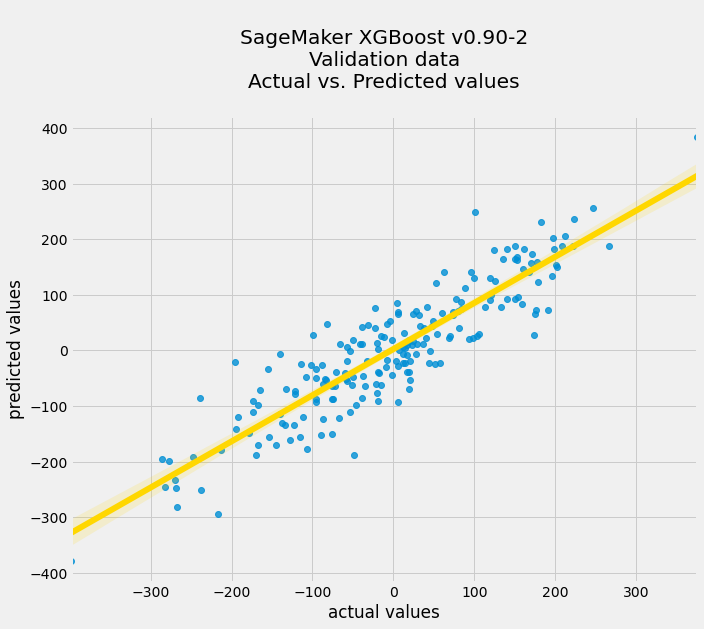

In [28]:
import seaborn as sns
import matplotlib.pylab as plt

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))

sns.regplot(validation_df['target'], xgb_preds, line_kws={'color': 'gold'})

plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("\nSageMaker XGBoost v0.90-2\nValidation data\nActual vs. Predicted values\n")

## Import the validation and evaluation csv files and initialize them as dataframes
---

In [30]:
valid_df = pd.read_csv('files/capstone/data/valid_data.csv')
eval_df = pd.read_csv('files/capstone/data/evaluation_data.csv')

In [31]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          200 non-null    float64
 1   lr_predictions  200 non-null    float64
 2   rf_predictions  200 non-null    float64
dtypes: float64(3)
memory usage: 4.8 KB


In [32]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   algorithm  2 non-null      object 
 1   MSE        2 non-null      float64
 2   r2_score   2 non-null      float64
dtypes: float64(2), object(1)
memory usage: 176.0+ bytes


In [33]:
valid_df['xgb_predictions'] = xgb_preds
valid_df.head()

,actual,lr_predictions,rf_predictions,xgb_predictions
0,223.0134034252,249.3815264658,184.2631966261,235.8849945068
1,103.5576338208,50.0589424148,26.2801230476,25.2129077911
2,208.8445850069,189.4567915501,168.0707990976,188.8748779297
3,-65.9373060424,-36.3245878977,40.2172843202,11.1564674377
4,-37.1861890218,-57.4402593434,-37.5017119609,-46.6220779419


### In the previous notebooks, the MSE was the metric value that was used to evaluate a model's performance. However, the MSE is highly biased for higher values. Therefore, the RMSE was computed instead using a helper function since it is objectively better in terms of reflecting performance when dealing with large error values. 
---

In [34]:
eval_df

,algorithm,MSE,r2_score
0,LinearRegression,2568.4943089018,83.9803530271
1,RandomForestRegressor,3877.7746257594,75.8143982138


In [37]:
valid_df.head()

,actual,lr_predictions,rf_predictions,xgb_predictions
0,223.0134034252,249.3815264658,184.2631966261,235.8849945068
1,103.5576338208,50.0589424148,26.2801230476,25.2129077911
2,208.8445850069,189.4567915501,168.0707990976,188.8748779297
3,-65.9373060424,-36.3245878977,40.2172843202,11.1564674377
4,-37.1861890218,-57.4402593434,-37.5017119609,-46.6220779419


In [38]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

# helper function for evaluating a model
def evaluate(labels, predictions):
    # get rmse values and r^2 scores 
    rmse = np.sqrt(MSE(labels, predictions))
    
    r2 = r2_score(labels, predictions)
    
    return rmse, r2

# get rmse values and r^2 scores using the helper function
lr_rmse, lr_r2 = evaluate(valid_df['actual'], valid_df['lr_predictions'])
rf_rmse, rf_r2 = evaluate(valid_df['actual'], valid_df['rf_predictions'])
xgb_rmse, xgb_r2 = evaluate(valid_df['actual'], valid_df['xgb_predictions'])

In [39]:
lr_data = {
    'algorithm': ['LinearRegression'],
    'RMSE': [lr_rmse],
    'r2_score': [lr_r2*100]
}

# init evaluation dataframe
eval_df = pd.DataFrame(lr_data)

rf_data = {
    'algorithm': 'RandomForestRegressor',
    'RMSE': rf_rmse,
    'r2_score': rf_r2*100
}

#append row to the dataframe
eval_df = eval_df.append(rf_data, ignore_index=True)

xgb_data = {
    'algorithm': 'SageMaker XGBoost v0.90-2',
    'RMSE': xgb_rmse,
    'r2_score': xgb_r2*100
}

#append row to the dataframe
eval_df = eval_df.append(xgb_data, ignore_index=True)
eval_df.sort_values(by=['r2_score'], ascending=False)

,algorithm,RMSE,r2_score
0,LinearRegression,50.6803148067,83.9803530271
2,SageMaker XGBoost v0.90-2,55.0096166566,81.1265380245
1,RandomForestRegressor,62.2717803323,75.8143982138


## Model evaluation

In this segment, the actual and predicted values were plotted for all three models using the seaborn library's regplot

---

<AxesSubplot:xlabel='actual', ylabel='xgb_predictions'>

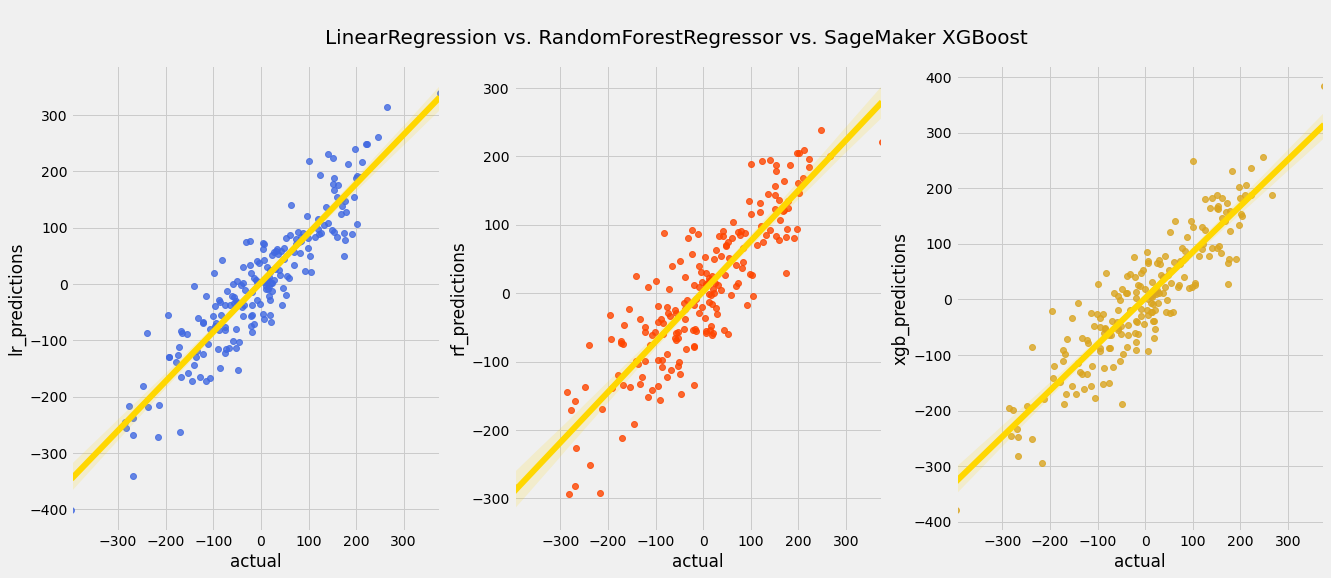

In [51]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

fig.suptitle('\nLinearRegression vs. RandomForestRegressor vs. SageMaker XGBoost\n', fontsize=20)

# sns.scatterplot(ax=axes[0], data=family_df, x='Special Occasions Expenditure', y='Total Household Income (Monthly)')
sns.regplot(ax=axes[0], data=valid_df, x='actual', y='lr_predictions', color='royalblue', line_kws={'color': 'gold'})
sns.regplot(ax=axes[1], data=valid_df, x='actual', y='rf_predictions', color='orangered', line_kws={'color': 'gold'})
sns.regplot(ax=axes[2], data=valid_df, x='actual', y='xgb_predictions', color='goldenrod', line_kws={'color': 'gold'})

## Data Visualization

In order to visualize the data better, all three graphs were combined into one figure. The first step to achieve this was to use the melt method to create a new 'cols' column
where the predictor identifiers were stored and aggregating all of the prediction values to a new 'vals' column as seen below.
---

In [44]:
valid_df

,actual,lr_predictions,rf_predictions,xgb_predictions
0,223.0134034252,249.3815264658,184.2631966261,235.8849945068
1,103.5576338208,50.0589424148,26.2801230476,25.2129077911
2,208.8445850069,189.4567915501,168.0707990976,188.8748779297
3,-65.9373060424,-36.3245878977,40.2172843202,11.1564674377
4,-37.1861890218,-57.4402593434,-37.5017119609,-46.6220779419
...,...,...,...,...
195,6.1954814836,-62.7173175911,-57.8528619217,-92.3018188477
196,-60.0924294199,-20.5887486583,-24.7069601858,-40.7066268921
197,-82.3578922244,42.1940842223,87.4981106287,48.3396949768
198,59.9966773530,86.9309505907,80.6346849867,67.9673995972


In [45]:
melted_valid_df = valid_df.melt('actual', var_name='cols',  value_name='vals')
melted_valid_df

,actual,cols,vals
0,223.0134034252,lr_predictions,249.3815264658
1,103.5576338208,lr_predictions,50.0589424148
2,208.8445850069,lr_predictions,189.4567915501
3,-65.9373060424,lr_predictions,-36.3245878977
4,-37.1861890218,lr_predictions,-57.4402593434
...,...,...,...
595,6.1954814836,xgb_predictions,-92.3018188477
596,-60.0924294199,xgb_predictions,-40.7066268921
597,-82.3578922244,xgb_predictions,48.3396949768
598,59.9966773530,xgb_predictions,67.9673995972


## Plot prediction values of all three models
---

Text(0.5, 0.98, '\nLinearRegression vs. RandomForestRegressor vs. SageMaker XGBoost\n')

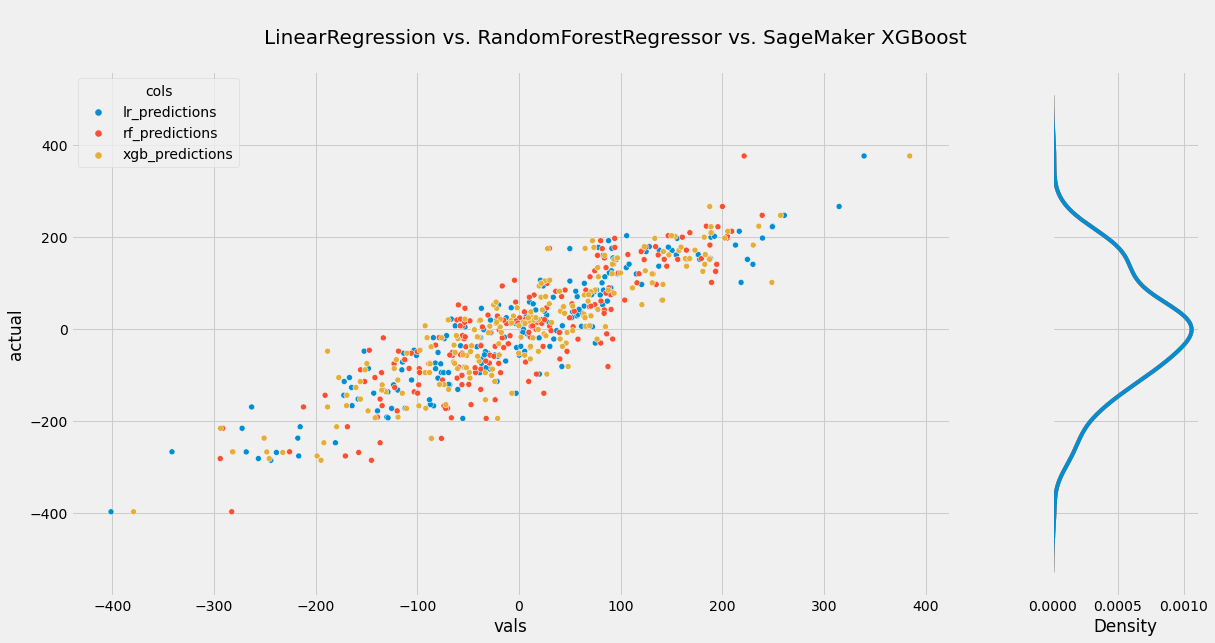

In [46]:
f, axs = plt.subplots(
    1, 2,
    figsize=(18,9),
    sharey=True,
    gridspec_kw=dict(width_ratios=[3,0.5])
)

sns.scatterplot(
    data=melted_valid_df,
    x='vals',
    y='actual',
    hue='cols',
    ax=axs[0]
)

sns.kdeplot(
    data=melted_valid_df,
    y='actual',
    hue='cols',
    ax=axs[1],
    legend=False
)

f.suptitle('\nLinearRegression vs. RandomForestRegressor vs. SageMaker XGBoost\n', fontsize=20)

## Check evaluation dataframes for consistency
---

In [47]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   actual           200 non-null    float64
 1   lr_predictions   200 non-null    float64
 2   rf_predictions   200 non-null    float64
 3   xgb_predictions  200 non-null    float32
dtypes: float32(1), float64(3)
memory usage: 5.6 KB


In [48]:
eval_df.sort_values(by=['r2_score'], ascending=False)

,algorithm,RMSE,r2_score
0,LinearRegression,50.6803148067,83.9803530271
2,SageMaker XGBoost v0.90-2,55.0096166566,81.1265380245
1,RandomForestRegressor,62.2717803323,75.8143982138


## Export model evaluation dataframes into csv files
---

In [49]:
# export data 
valid_df.to_csv('files/capstone/data/final_valid_data.csv', index=False)
eval_df.to_csv('files/capstone/data/final_evaluation_data.csv', index=False)